In [489]:
# dependencies
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
import json
import os
import json
import timeit
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib as plt
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')

# options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 200

## Gathering Data for this Project

#### 1. WeRateDogs Twitter Archive

In [490]:
df_1 = pd.read_csv('twitter-archive-enhanced.csv')

#### 2. Tweet Image Predictions

In [491]:
# download tsv using Requests library
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url, allow_redirects = True)
open('image_predictions.tsv', 'wb').write(r.content)

# import the tsv file containing ANN image predictions
df_2 = pd.read_csv('image_predictions.tsv', sep='\t')

#### 3. Twitter API Query
Unfortunately I was denied by the Twitter to have a developers account. Seemed like a bot was stuck in a loop contacting me. I sent verbatim the recommended script by Udacity for approval but they responded asking for "more" information, although they just asked for the same information again. I retried, this time following the same ideas but in my own words and again they responded they needed more information. After the third attempt they said I was denied developers access.

So below is the code and data supplied by Udacity, although it's dissapointing taking this way out. A recommendation for Udacity is to give a heads up that something like this may be required for a project, like when the studen starts the module. Only concerning from a time perspective, I would have tried setting up the Twitter developers acount earlier when I had more time. The initial request took 18 hours to get a response. In total it was 48 hours between all the back and forth. If I was more pressed for time this could have been a problem for a student closing in a on due date.

```python
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
```

In [492]:
# convert the JSON data in tweet_json.txt to a pandas dataframe
tweets_data = []
tweet_file = open('tweet_json.txt', "r")
for line in tweet_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue   
tweet_file.close()
tweet_info = pd.DataFrame()

# populate the dataframe with desired data columns
def simple_tweet(tweet):
    """extract fields of interest from tweet dict"""
    return {key: tweet[key]
            for key in ['id', 'retweet_count', 'favorite_count']}
tweets = [simple_tweet(tweet) for tweet in tweets_data]
df_3 = pd.DataFrame(tweets)

### Make Copies of the Data Before Cleaning

In [493]:
We_Rate_Dogs = df_1.copy()
Tweet_Image_Predictions = df_2.copy()
Twitter_API_Query = df_3.copy()

## Assessing Data for this Project

#### WeRateDogs Twitter Archive

In [494]:
print(df_1.shape)
print('-' * 20)
print(df_1.info())
print('-' * 20)
print(df_1.head())

(2356, 17)
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object


In [495]:
df_1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [496]:
# check there are no duplicates
df_1['tweet_id'].nunique()

2356

In [497]:
df_1['rating_denominator'].unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2], dtype=int64)

In [498]:
# seeing if denominator feature is really necessary
rows = df_1.shape[0]
EQ, LT, GT = 0, 0, 0
for index, row in df_1.iterrows():
    if df_1['rating_numerator'][index] == df_1['rating_denominator'][index]:
        EQ += 1
    if df_1['rating_numerator'][index] < df_1['rating_denominator'][index]:
        LT += 1   
    if df_1['rating_numerator'][index] > df_1['rating_denominator'][index]:
        GT += 1 
print('total rows: ' + str(rows))
print(f'Equals: {EQ} / Less than: {LT} / Greater than: {GT}')
print(f'Sum of counts: {EQ+LT+GT}')
# at first I thought all the ratings would be greater than one, but it's not the case. The denominator is necessary.

total rows: 2356
Equals: 463 / Less than: 442 / Greater than: 1451
Sum of counts: 2356


In [499]:
df_1.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
431,820837357901512704,NaN,NaN,2017-01-16 03:37:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Finn. He's wondering if you come here often. Fr*ckin flirtatious af. 12/10 would give number to https://t.co/ii5eNX5…,8.192277e+17,4.196984e+09,2017-01-11 17:01:16 +0000,https://twitter.com/dog_rates/status/819227688460238848/photo/1,12,10,Finn,None,None,None,None
1593,686386521809772549,NaN,NaN,2016-01-11 03:17:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Crimson. He's a Speckled Winnebago. Main passions are air hockey &amp; parkour. 11/10 would pet thoroughly https://t.co/J5aI7SjzDc,NaN,NaN,NaN,https://twitter.com/dog_rates/status/686386521809772549/photo/1,11,10,Crimson,None,None,None,None
2272,667491009379606528,NaN,NaN,2015-11-19 23:53:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Two dogs in this one. Both are rare Jujitsu Pythagoreans. One slightly whiter than other. Long legs. 7/10 and 8/10 https://t.co/ITxxcc4v9y,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667491009379606528/photo/1,7,10,None,None,None,None,None
1415,698703483621523456,NaN,NaN,2016-02-14 03:01:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Rusty. He has no respect for POULTRY products. Unbelievable af. 7/10 would still pet https://t.co/hEH19t1eFp,NaN,NaN,NaN,https://twitter.com/dog_rates/status/698703483621523456/photo/1,7,10,Rusty,None,None,None,None
1390,700151421916807169,NaN,NaN,2016-02-18 02:54:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",If a pupper gave that to me I'd probably start shaking and faint from all the joy. 11/10 https://t.co/o9aJVPB25n,NaN,NaN,NaN,https://twitter.com/dog_rates/status/700151421916807169/photo/1,11,10,None,None,None,pupper,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388333682689/photo/1,13,10,None,None,None,None,puppo
1805,676942428000112642,NaN,NaN,2015-12-16 01:50:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Who leaves the last cupcake just sitting there? 9/10 https://t.co/PWMqAoEx2a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676942428000112642/photo/1,9,10,None,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2240,667924896115245057,NaN,NaN,2015-11-21 04:37:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jiminy. He has always wanted to be a cheerleader. Can jump high enough to get on other dog. Go Jiminy. 9/10 https://t.co/fW6kIPFGD2,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667924896115245057/photo/1,9,10,Jiminy,None,None,None,None
569,801958328846974976,NaN,NaN,2016-11-25 01:18:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Ronnie. He hopes you're having a great day. Nifty tongue slip. 12/10 would pat head approvingly https://t.co/4fY2bsAm65,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801958328846974

In [500]:
count = df_1.groupby('doggo').doggo.count()
print('doggo count ' + str(count[1]))
count = df_1.groupby('floofer').floofer.count()
print('floofer count  ' + str(count[1]))
count = df_1.groupby('pupper').pupper.count()
print('pupper count  ' + str(count[1]))
count = df_1.groupby('puppo').puppo.count()
print('puppo count  ' + str(count[1]))

doggo count 97
floofer count  10
pupper count  257
puppo count  30


In [501]:
df_1['source'].nunique()

4

In [502]:
df_1['expanded_urls'].nunique()

2218

In [503]:
# check the dog type catagory 
cats = ['doggo', 
        'floofer',
        'pupper',
        'puppo',]

for c in cats:
    print(df_1[c].count())
    print(df_1[c].nunique())
    print(df_1[c].unique())

2356
2
['None' 'doggo']
2356
2
['None' 'floofer']
2356
2
['None' 'pupper']
2356
2
['None' 'puppo']


### Tweet Image Predictions

In [504]:
print(df_2.shape)
print('-' * 20)
print(df_2.info())
print('-' * 20)
print(df_2.head())

(2075, 12)
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB
None
--------------------
             tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3  666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4

In [505]:
# check there are no duplicates
df_2['tweet_id'].nunique()

2075

In [506]:
df_2['img_num'].nunique()

4

In [507]:
df_2.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


### Twitter API Query

In [508]:
print(df_3.shape)
print('-' * 20)
print(df_3.info())
print('-' * 20)
print(df_3.head())

(838, 3)
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 3 columns):
favorite_count    838 non-null int64
id                838 non-null int64
retweet_count     838 non-null int64
dtypes: int64(3)
memory usage: 19.7 KB
None
--------------------
   favorite_count                  id  retweet_count
0           39467  892420643555336193           8853
1           33819  892177421306343426           6514
2           25461  891815181378084864           4328
3           42908  891689557279858688           8964
4           41048  891327558926688256           9774


In [509]:
df_3.describe()

,favorite_count,id,retweet_count
count,838.000000,8.380000e+02,838.000000
mean,15188.225537,8.245384e+17,5736.091885
std,15236.248317,3.469656e+16,6515.024337
min,0.000000,7.671914e+17,0.000000
25%,5900.750000,7.944983e+17,2351.250000
50%,11913.000000,8.222039e+17,3890.000000
75%,21572.000000,8.521307e+17,6542.750000
max,132810.000000,8.924206e+17,56625.000000


In [510]:
df_3.sample(10)

,favorite_count,id,retweet_count
592,8246,798925684722855936,1663
668,0,790227638568808452,4190
226,20229,848324959059550208,4037
142,31459,864197398364647424,9616
222,17039,849412302885593088,3487
239,48410,846514051647705089,13076
40,27478,884441805382717440,5856
511,8429,811744202451197953,1884
718,18908,783391753726550016,6441
435,3706,820314633777061888,648


In [511]:
# check there are no duplicates
df_3['id'].nunique()

838

### Quality Issues
#### WeRateDogs Twitter Archive
- 'timestamp' is the incorrect datatype.
- 'in_reply_to_status_id', 'in_reply_user_id','retweeted_status_id', 'retweeted_status_user_id',                      'retweeted_status_timestamp' are incomplete and should not be included in the data set.
- 'source' and 'expanded URLs' don't add anything to reporting the data.
- dog 'stage' should be catagorical.
- Incorrect values in rating numerators
- different denominators, should create "rating" from numerator and denominator
#### Tweet Image Predictions
- 'p1_dog', 'p2_dog', and 'p3_dog' add no value and should be dropped
- all dog breed need to be formatted for capitolized letters or not
- remove '\_' and '-' in 'p1', 'p2', 'p3'
- remove mislabeled breeds like 'dishwasher' and consolidate breeds into a single column of the highest probability
    - if all three values in the prediction column are not dogs the row will be dropped
- 'img_num' should be catagorical
#### Twitter API Query
- There is only one cleaning activity for this data set, the match the feature name 'id' with the other two dataframes

### Titidness Issues
#### WeRateDogs Twitter Archive
- rename 'text' column to 'description'.
- 'doggo', 'floofer', 'pupper', 'puppo' should be a single column.
#### Tweet Image Predictions
- 'img_num' should be renamed
- rename 'p1', 'p2', 'p3' to something that makes more sense
#### General 
- data sets need to be merged into a single set.

## Cleaning Data for this Project

__Define__

- 'timestamp' is the incorrect datatype.

__Code__

In [512]:
df_1['timestamp'] = pd.to_datetime(df_1['timestamp'])

__Test__

In [513]:
print(df_1['timestamp'].dtypes)

datetime64[ns]


__Define__

- 'in_reply_to_status_id', 'in_reply_user_id','retweeted_status_id', 'retweeted_status_user_id',                      'retweeted_status_timestamp' are incomplete and should not be included in the data set.
- 'source' and 'expanded URLs' don't add anything to reporting the data.

__Code__

In [514]:
cats = ['in_reply_to_status_id',
        'in_reply_to_user_id',
        'retweeted_status_id', 
        'retweeted_status_user_id', 
        'retweeted_status_timestamp',
        'expanded_urls',
        'source',]
for c in cats:
    df_1.drop(c, axis=1, inplace = True) 

__Test__

In [515]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null datetime64[ns]
text                  2356 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 184.1+ KB


__Define__

- 'doggo', 'floofer', 'pupper', 'puppo' should be a single column.

__Code__

In [516]:
categories = ['doggo',
              'floofer',
              'pupper',
              'puppo']
for cat in categories:
    df_1.loc[df_1[cat] == 'None', cat] = np.NaN
df_1['stages'] = df_1[['doggo', 'floofer', 'pupper', 'puppo']].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)
for cat in categories:
    df_1.drop(cat, axis=1, inplace = True) 
df_1.replace('', np.NaN, inplace=True)

__Test__

In [517]:
df_1.dropna(subset=['stages']).loc[191:220]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
191,855851453814013952,2017-04-22 18:31:02,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,13,10,None,"doggo, puppo"
199,854120357044912130,2017-04-17 23:52:16,Sometimes you guys remind me just how impactful a pupper can be. Cooper will be remembered as a good boy by so many. 14/10 rest easy friend https://t.co/oBL7LEJEzR,14,10,None,pupper
200,854010172552949760,2017-04-17 16:34:26,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",11,10,None,"doggo, floofer"
211,851953902622658560,2017-04-12 00:23:33,RT @dog_rates: This is Astrid. She's a guide doggo in training. 13/10 would follow anywhere https://t.co/xo7FZFIAao,13,10,Astrid,doggo
220,850019790995546112,2017-04-06 16:18:05,Say hello to Boomer. He's a sandy pupper. Having a h*ckin blast. 12/10 would pet passionately https://t.co/ecb3LvExde,12,10,Boomer,pupper


__Define__

- dog 'stage' should be catagorical.

__Code__

In [518]:
df_1['stages'] = df_1['stages'].astype('category')

__Test__

In [519]:
print(df_1['stages'].dtypes)

category


__Define__

- Incorrect values in rating numerators

__Code__

In [520]:
ratings = df_1.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
df_1 = df_1.merge(ratings, how='outer', left_index=True, right_index=True)
category = ['rating_numerator',
             'rating_denominator']
for cat in category:
    df_1.drop(cat, axis=1, inplace = True)
df_1.rename(columns={0: 'rating_numerator', 1:'rating_denominator'}, inplace = True)
df_1['rating_numerator'] = df_1['rating_numerator'].astype(float)
df_1['rating_denominator'] = df_1['rating_denominator'].astype(float)

__Test__

In [521]:
df_1.loc[695]

tweet_id                                                                                                                            786709082849828864
timestamp                                                                                                                          2016-10-13 23:23:56
text                  This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
name                                                                                                                                             Logan
stages                                                                                                                                             NaN
rating_numerator                                                                                                                                  9.75
rating_denominator                                                                            

__Define__

- different denominators, should create "rating" from numerator and denominator

__Code__

In [522]:
df_1['rating'] = ''
df_1['rating'] = df_1['rating_numerator'] / df_1['rating_denominator']

__Test__

In [523]:
df_1.sample(3)

,tweet_id,timestamp,text,name,stages,rating_numerator,rating_denominator,rating
435,820446719150292993,2017-01-15 01:45:15,RT @dog_rates: This is Peaches. She's the ultimate selfie sidekick. Super sneaky tongue slip appreciated. 13/10 https://t.co/pbKOesr8Tg,Peaches,NaN,13.0,10.0,1.3
1340,704859558691414016,2016-03-02 02:43:09,Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper https://t.co/81mvJ0rGRu,a,pupper,10.0,10.0,1.0
1732,679828447187857408,2015-12-24 00:58:27,Everybody look at this beautiful pupper 13/10 https://t.co/hyAC5Hq9GC,None,pupper,13.0,10.0,1.3


__Define__

- 'p1_dog', 'p2_dog', and 'p3_dog' add no value and should be dropped

__Code__

In [524]:
category = ['p1_dog',
            'p2_dog',
            'p3_dog']
for cat in category:
    df_2.drop(cat, axis=1, inplace = True)

__Test__

In [525]:
df_2.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p2,p2_conf,p3,p3_conf
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,collie,0.156665,Shetland_sheepdog,0.061428


__Define__

- remove '\_', '-', and '\_' in 'p1', 'p2', 'p3'
- all dog breed need to be formatted for capitolized letters or not

__Code__

In [526]:
for col in ['p1', 'p2', 'p3']:
    df_2[col] = df_2[col].str.replace('_',' ')
    df_2[col] = df_2[col].str.replace('-',' ') 
    df_2[col] = df_2[col].str.title()

__Test__

In [527]:
counter_in_case = 0
for column in ['p1', 'p2', 'p3']:
    col = df_2[column]
    for x in range(len(col)):
        if col[x].find('-') is not -1:
            print('found')
            counter_in_case =+ 1
        else:
            pass
if counter_in_case == 0: print('none found')

none found


__Define__

- rename 'p1', 'p2', 'p3' to something that makes more sense

__Code__

In [528]:
df_2.rename(columns={'p1': 'breed_probability_1', 'p2': 'breed_probability_2', 'p3': 'breed_probability_3'}, inplace = True)

__Test__

In [529]:
df_2.head()

,tweet_id,jpg_url,img_num,breed_probability_1,p1_conf,breed_probability_2,p2_conf,breed_probability_3,p3_conf
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,Collie,0.156665,Shetland Sheepdog,0.061428
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,Miniature Pinscher,0.074192,Rhodesian Ridgeback,0.072010
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,Malinois,0.138584,Bloodhound,0.116197
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,Redbone,0.360687,Miniature Pinscher,0.222752
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,Rottweiler,0.243682,Doberman,0.154629


__Define__

- remove mislabeled breeds like 'dishwasher' and consolidate breeds into a single column of the highest probability
    - if all three values in the prediction column are not dogs the row will be dropped

Scraping a list of dog breeds from [dogtime.com](https://dogtime.com/dog-breeds/profiles) to compare with df_2['p1', 'p2', 'p3']. As a note, I realize this scraped list from dogtime.com is not comprehensive and because of this there are some inconsistancies between the list and the data set the comparison is not perfect. It was more for the sake of a scraping exercise to gather more data because I could not do the Twitter API portion and to show that I idenified the errors in the Tweet Image Predictions data set. This would obviously be scrubbed more thoroughly in a real world activity.

__Code__

In [530]:
#specify the URL
page = requests.get('https://dogtime.com/dog-breeds/profiles')
# check the response
page

<Response [200]>

In [531]:
# check that it worked
page.status_code

200

In [532]:
soup = BeautifulSoup(page.content, 'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<!--[if IE 8]> <html class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!-->
<html class="no-js">
 <!--<![endif]-->
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
  <meta content="bc06c90d1acb18ed0abe8e9b9c02db20" name="p:domain_verify">
   <meta content="width=device-width, initial-scale=1, maximum-scale=1, minimal-ui" name="viewport"/>
   <title>
    All Dog Breeds - Complete List of Dog Profiles
   </title>
   <style>
    *,.top-nav .menu{box-sizing:border-box}.coverpanel,.coverpanel-wrapper,.ir,.toggle-menu,.top-logo,.top-nav .menu .menu-item,svg:not(:root){overflow:hidden}.search-field,img{vertical-align:middle}.fb_reset,.top-logo,a{text-decoration:none}.home .content{padding:0 8px 8px}.home.main .widget_pb_coverpanel_widget{margin:0 -8px;min-height:314px}.sidebar-top,.top-300-promo,.top-300-promo .promo{min-height:250px}.coverpanel{position:relative;width:100%;max-width:414px;margin:0 auto;max-height:370px}.ho

In [533]:
# create the list of dog breeds
breeds = []
soup_dump = soup.findAll('a', class_ = 'post-title')
for breed in soup_dump:
    breed = str(breed).split('>', 1)
    breed = breed[1].split('<', 1)
    breeds.append(breed[0])
breeds

['Affenpinscher',
 'Afghan Hound',
 'Airedale Terrier',
 'Akita',
 'Alaskan Klee Kai',
 'Alaskan Malamute',
 'American Bulldog',
 'American English Coonhound',
 'American Eskimo Dog',
 'American Foxhound',
 'American Pit Bull Terrier',
 'American Staffordshire Terrier',
 'American Water Spaniel',
 'Anatolian Shepherd Dog',
 'Appenzeller Sennenhunde',
 'Australian Cattle Dog',
 'Australian Kelpie',
 'Australian Shepherd',
 'Australian Terrier',
 'Azawakh',
 'Barbet',
 'Basenji',
 'Basset Hound',
 'Beagle',
 'Bearded Collie',
 'Bedlington Terrier',
 'Belgian Malinois',
 'Belgian Sheepdog',
 'Belgian Tervuren',
 'Berger Picard',
 'Bernedoodle',
 'Bernese Mountain Dog',
 'Bichon Frise',
 'Black and Tan Coonhound',
 'Black Mouth Cur',
 'Black Russian Terrier',
 'Bloodhound',
 'Blue Lacy',
 'Bluetick Coonhound',
 'Boerboel',
 'Bolognese',
 'Border Collie',
 'Border Terrier',
 'Borzoi',
 'Boston Terrier',
 'Bouvier des Flandres',
 'Boxer',
 'Boykin Spaniel',
 'Bracco Italiano',
 'Briard',
 'B

In [534]:
# check the predicted dog breed values again the scraped list and mark as 'NaN' if not matches,
# then drop the rows that all three are 'NaN'
for index, row in df_2.iterrows():
    if not any(breed == row[3] for breed in breeds):
        row[3] = 'NaN'
    df_2.loc[index, 'breed_probability_1'] = row[3]
    if not any(breed == row[5] for breed in breeds):
        row[5] = 'NaN'
    df_2.loc[index, 'breed_probability_2'] = row[5]
    if not any(breed == row[7] for breed in breeds):
        row[7] = 'NaN'
    df_2.loc[index, 'breed_probability_3'] = row[7]
    if df_2['breed_probability_1'][index] and df_2['breed_probability_2'][index] and df_2['breed_probability_3'][index] == 'NaN': df_2.drop(index, inplace=True)

In [535]:
# create new columns with 'most probable' dog breed and and confidence level. Drop the originals
df_2['most_probable_breed'] = ''
df_2['breed_confidence'] = ''
length = len(df_2)
for index, row in df_2.iterrows():
    if df_2['breed_probability_1'][index] != 'NaN':
        df_2.loc[index, 'most_probable_breed'] = row[3]
        df_2.loc[index, 'breed_confidence'] = row[4]
    else:
        if df_2['breed_probability_2'][index] != 'NaN':
            df_2.loc[index, 'most_probable_breed'] = row[5]
            df_2.loc[index, 'breed_confidence'] = row[6]
        else:
            df_2.loc[index, 'most_probable_breed'] = row[7]
            df_2.loc[index, 'breed_confidence'] = row[8]
# drop columns
df_2.drop(['breed_probability_1',
           'p1_conf',
           'breed_probability_2',
           'p2_conf',
           'breed_probability_3',
           'p3_conf'], axis=1, inplace=True)
# change the breed_confidence feature to a float
df_2['breed_confidence'] = df_2['breed_confidence'].astype('float')

In [536]:
df_2['most_probable_breed'] = df_2['most_probable_breed'].astype('category')

In [537]:
# just to how how much data has been lost
print(Tweet_Image_Predictions.shape)
print(df_2.shape)

(2075, 12)
(954, 5)


In [538]:
df_2.sample(3)

,tweet_id,jpg_url,img_num,most_probable_breed,breed_confidence
39,666649482315059201,https://pbs.twimg.com/media/CUBqKnLWwAA5OQB.jpg,1,Border Collie,0.447803
818,692901601640583168,https://pbs.twimg.com/media/CZ2uU37UcAANzmK.jpg,1,Soft Coated Wheaten Terrier,0.403496
638,681281657291280384,https://pbs.twimg.com/media/CXRmDfWWMAADCdc.jpg,1,Saint Bernard,0.998830


__Define__

- 'img_num' should be catagorical
- 'img_num' should be renamed

__Code__

In [539]:
df_2.rename(columns={'img_num': 'tweet_image_number'}, inplace = True)
df_2['tweet_image_number'] = df_2['tweet_image_number'].astype('category')

__Test__

In [540]:
df_2['tweet_image_number'].dtypes

CategoricalDtype(categories=[1, 2, 3, 4], ordered=False)

__Define__

- rename the Twitter API Query feature 'id' to 'tweet_id' to match other dataframes

__Code__

In [541]:
df_3.rename(columns={'id': 'tweet_id'}, inplace = True)

__Test__

In [542]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 3 columns):
favorite_count    838 non-null int64
tweet_id          838 non-null int64
retweet_count     838 non-null int64
dtypes: int64(3)
memory usage: 19.7 KB


__Define__

- rename 'text' column to 'description'.

__Code__

In [543]:
df_1.rename(columns={'text': 'description'}, inplace = True)

__Test__

In [544]:
df_1.sample()

,tweet_id,timestamp,description,name,stages,rating_numerator,rating_denominator,rating
2072,671109016219725825,2015-11-29 23:30:32,This is Toby. He asked for chocolate cake for his birthday but was given vanilla instead. 8/10 it'll be ok Toby https://t.co/sYi2G0he4H,Toby,NaN,8.0,10.0,0.8


### Merging

In [545]:
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)

(2356, 8)
(954, 5)
(838, 3)


In [546]:
df = pd.merge(df_1, df_2, on='tweet_id') # happening because of stages NaN to 'None line a couple up'
df = pd.merge(df, df_3, on='tweet_id')
print(df.shape) 

(330, 14)


In [547]:
df.sample(3)

,tweet_id,timestamp,description,name,stages,rating_numerator,rating_denominator,rating,jpg_url,tweet_image_number,most_probable_breed,breed_confidence,favorite_count,retweet_count
11,885528943205470208,2017-07-13 15:58:47,This is Maisey. She fell asleep mid-excavation. Happens to the best of us. 13/10 would pat noggin approvingly https://t.co/tp1kQ8i9JF,Maisey,NaN,13.0,10.0,1.3,https://pbs.twimg.com/media/DEoH3yvXgAAzQtS.jpg,1,Pug,0.369275,36689,6683
195,813081950185472002,2016-12-25 18:00:17,This is Baron. He's officially festive as h*ck. Thinks it's just a fancy scarf. 11/10 would pat head approvingly https://t.co/PjulYEXTvg,Baron,NaN,11.0,10.0,1.1,https://pbs.twimg.com/media/C0ilsa1XUAEHK_k.jpg,2,Miniature Pinscher,0.023004,10989,3220
108,839239871831150596,2017-03-07 22:22:32,This is Odie. He's big. 13/10 would attempt to ride https://t.co/JEXB9RwBmm,Odie,NaN,13.0,10.0,1.3,https://pbs.twimg.com/media/C6WUNadWYAAPxHv.jpg,3,Newfoundland,0.050009,29684,7422


In [548]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 0 to 329
Data columns (total 14 columns):
tweet_id               330 non-null int64
timestamp              330 non-null datetime64[ns]
description            330 non-null object
name                   330 non-null object
stages                 52 non-null category
rating_numerator       330 non-null float64
rating_denominator     330 non-null float64
rating                 330 non-null float64
jpg_url                330 non-null object
tweet_image_number     330 non-null category
most_probable_breed    330 non-null category
breed_confidence       330 non-null float64
favorite_count         330 non-null int64
retweet_count          330 non-null int64
dtypes: category(3), datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 35.5+ KB


In [549]:
df.describe()

,tweet_id,rating_numerator,rating_denominator,rating,breed_confidence,favorite_count,retweet_count
count,3.300000e+02,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000
mean,8.238921e+17,12.419697,10.172727,1.223268,0.425231,17688.309091,5428.848485
std,3.470368e+16,4.158385,3.307519,0.165215,0.343227,15912.998988,6079.098140
min,7.675005e+17,3.000000,7.000000,0.300000,0.000056,0.000000,83.000000
25%,7.951039e+17,12.000000,10.000000,1.200000,0.088445,8911.250000,2490.250000
50%,8.201334e+17,12.000000,10.000000,1.200000,0.363272,13306.000000,3661.000000
75%,8.518633e+17,13.000000,10.000000,1.300000,0.735043,23052.000000,6007.250000
max,8.921774e+17,84.000000,70.000000,3.428571,0.999828,132810.000000,48265.000000


## Storing, Analyzing, and Visualizing Data for this Project

In [550]:
df.to_csv('twitter_archive_master.csv')

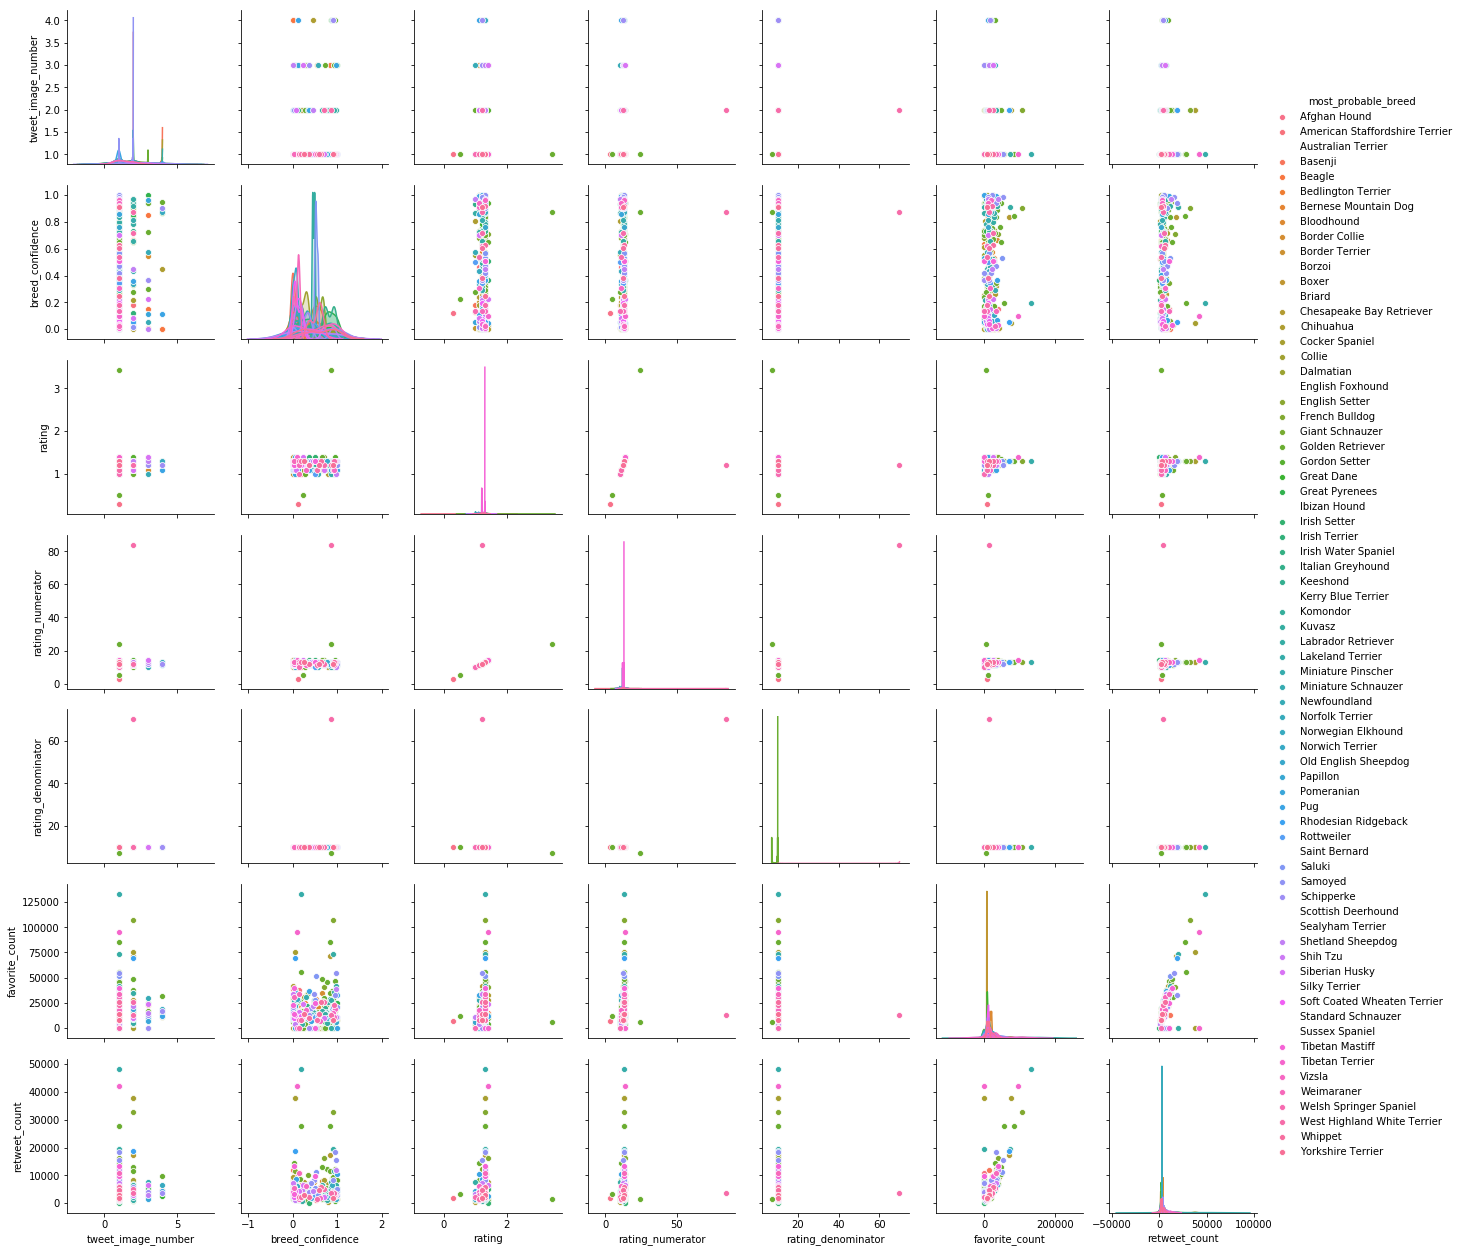

In [553]:
sns.pairplot(df[['tweet_image_number','breed_confidence', 'rating', 'rating_numerator', 'rating_denominator', 'stages', 'favorite_count', 'retweet_count', 'most_probable_breed']], hue = 'most_probable_breed')

A closer look a the only really positive correlation in the dataframe

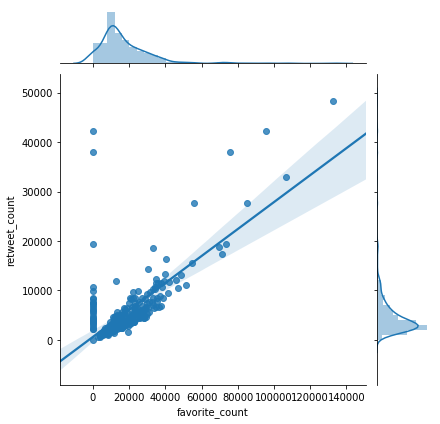

In [554]:
sns.jointplot(x='favorite_count', y='retweet_count', data=df, kind="reg")

Interesting that the majority of observations used the first image in the tweet to make the breed classification, yet the further into the higher the image number used, technically had a higher correlation in the breed confidence level.

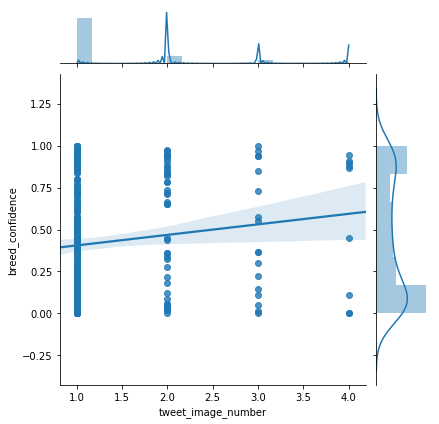

In [558]:
sns.jointplot(x='tweet_image_number', y='breed_confidence', data=df, kind="reg")

We can see a generally positive correlation between the dog's rating and retweet favorites which makes sense of course. The regression line is pulled down quite a bit also because of the outliers.

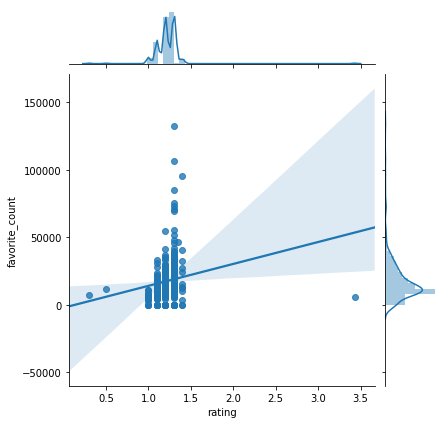

In [565]:
sns.jointplot(x='rating', y='favorite_count', data=df, kind="reg")

Because there was such a strong correlation between retween count and favorite count, it's not a surprse theres a similar pattern here between retweet count and normalized rating - just like above

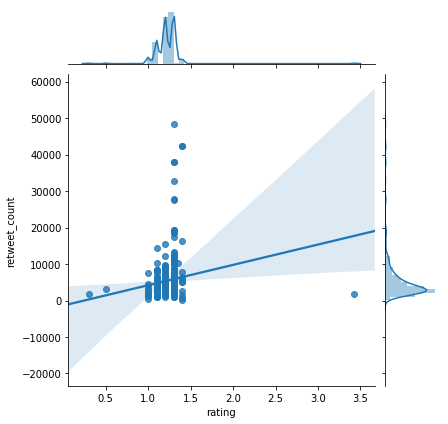

In [569]:
sns.jointplot(x='rating', y='retweet_count', data=df, kind="reg")

No particular breed appears to have been failing the classification earlier than another breed based on the image number used, i.e. for instance there isn't all or the majority of 'Beagle' points in the forth row.

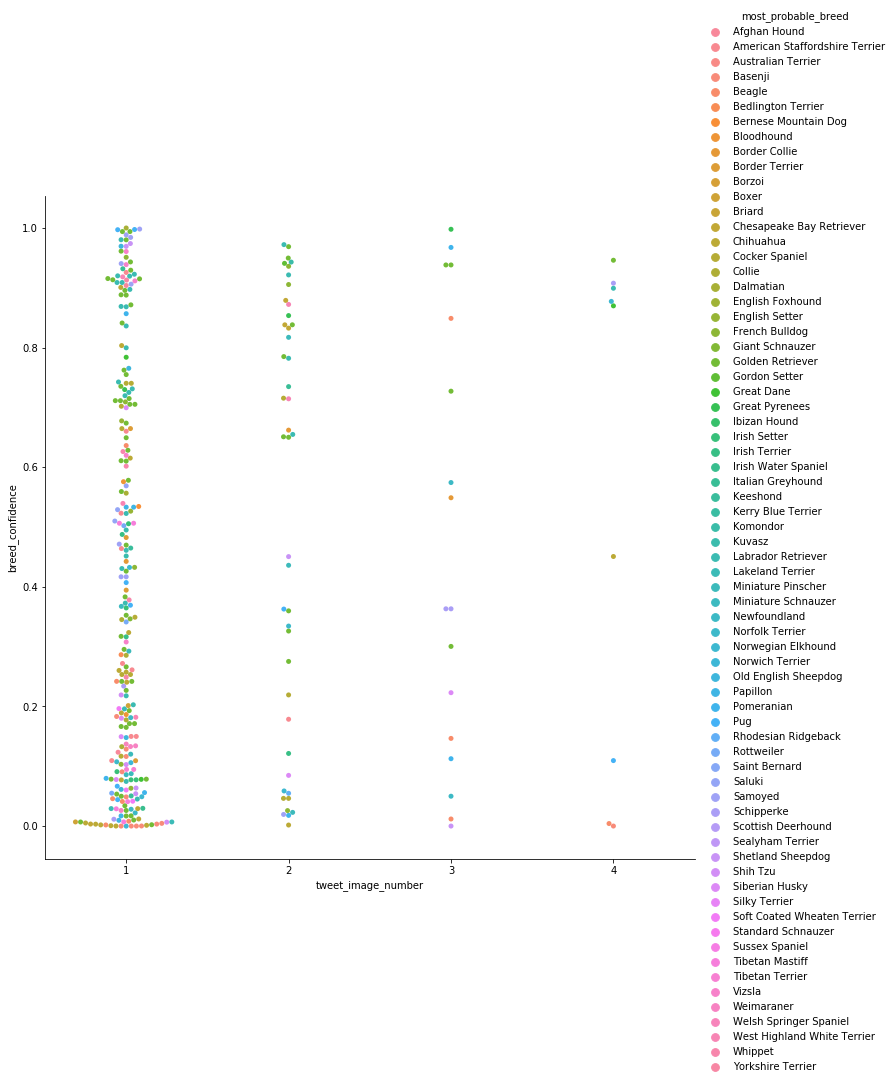

In [566]:
sns.catplot(x="tweet_image_number", y="breed_confidence", hue="most_probable_breed", kind="swarm", data=df, legend_out = True, height=10, aspect=1)

Here's a list of the most popular K-9's dictated by retween counts.

In [567]:
most_popular = df.groupby('most_probable_breed')['retweet_count'].sum().reset_index().sort_values(by='retweet_count', ascending=False)
most_popular

,most_probable_breed,retweet_count
22,Golden Retriever,370369
35,Labrador Retriever,156347
15,Cocker Spaniel,118032
14,Chihuahua,92744
20,French Bulldog,87181
63,Tibetan Terrier,84456
51,Samoyed,79385
3,Basenji,59647
36,Lakeland Terrier,50300
1,American Staffordshire Terrier,50150


A visualization for the most popular breed.

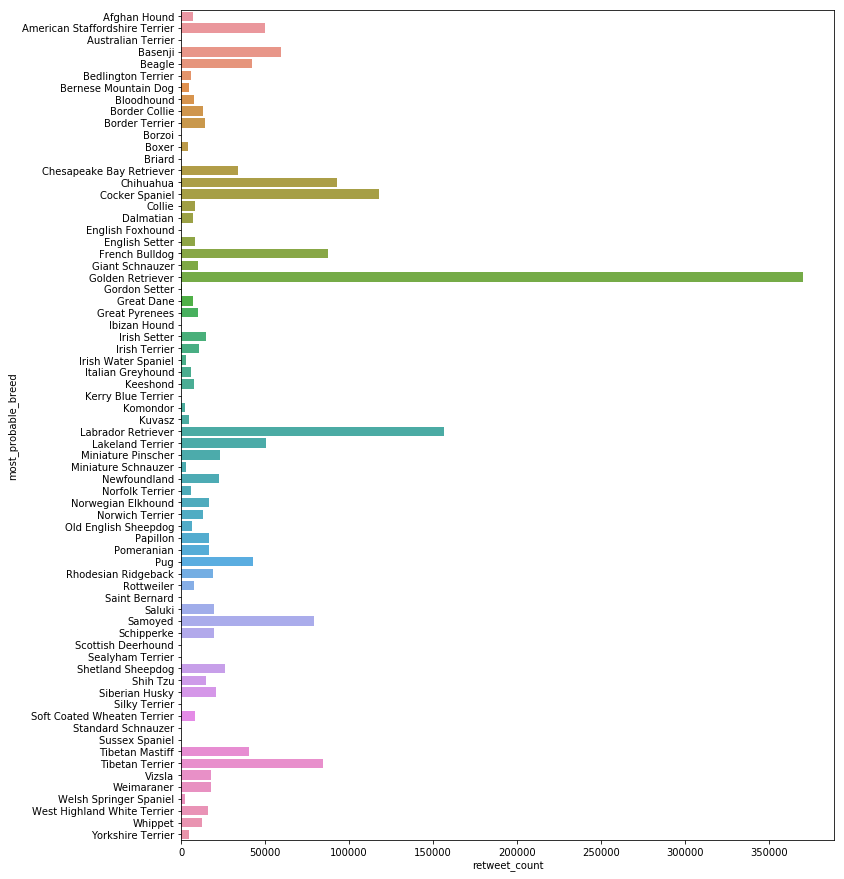

In [568]:
a4_dims = (11.7, 15.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.barplot(ax=ax, x='retweet_count',y='most_probable_breed',data=most_popular)